In [1]:
import wandb
import matplotlib.pyplot as plt
import dice_ml
import warnings
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from dice_ml.explainer_interfaces.explainer_base import UserConfigValidationException
import plotly.graph_objects as go
from datetime import timedelta
from scripts.SEP_CFE_functions import *
from slim_tsf.func._slim_TSF import SlimTimeSeriesForestClassifier
from aeon.utils.numba.stats import row_mean
import re
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import dice_ml
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score, make_scorer, roc_auc_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import seaborn as sns
import joblib
import os
from sklearn.preprocessing import MinMaxScaler
from scripts.SEP_CFE_functions import *
min_max_scaler = MinMaxScaler()
warnings.filterwarnings("ignore")

/Users/pranjal/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/pranjal/Library/Python/3.9/lib/python/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/Users/pranjal/Library/Python/3.9/lib/python/site-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' 

In [2]:
DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/processed/"

In [3]:
train_df = pd.read_csv(DATA_DIR + "train_top20_rowmean.csv", sep=',')
test_df = pd.read_csv(DATA_DIR + "test_top20_rowmean.csv", sep=',')
val_df = pd.read_csv(DATA_DIR + "val_top20_rowmean.csv", sep=',')
combined_df = pd.read_csv(DATA_DIR + "combined_top20_rowmean_with_filelist.csv", sep=',')


In [4]:
X_train = train_df.drop(columns=['label'])
y_train = train_df['label']
X_test = test_df.drop(columns=['label'])
y_test = test_df['label']
X_val = val_df.drop(columns=['label'])
y_val = val_df['label']


In [5]:
print(X_train.head())

   long_mean_@[300:660]  long_mean_@[396:636]  long_mean_@[420:660]  \
0              0.000002              0.000002              0.000002   
1              0.000001              0.000001              0.000002   
2              0.000001              0.000001              0.000001   
3              0.000005              0.000002              0.000002   
4              0.000004              0.000004              0.000005   

   long_mean_@[480:660]  long_mean_@[540:660]  p3_flux_ic_mean_@[300:480]  \
0          1.843730e-06              0.000002                    0.129404   
1          1.744159e-06              0.000002                    0.126223   
2          9.902296e-07              0.000001                    0.152870   
3          1.425889e-06              0.000001                    0.669969   
4          5.386373e-06              0.000007                    0.193647   

   p3_flux_ic_mean_@[300:540]  p3_flux_ic_mean_@[300:660]  \
0                    0.128755                    

In [6]:

##Define the hyperparameter grid
# param_grid = {
#     'n_estimators': [50, 100, 200, 300, 400, 500],
#     'max_depth': [2, 3, 4, 5, 6, 7, 8]
# }
# rf_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
#
# # Define a stratified k-fold cross-validation strategy
# cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
#
# # Define a scorer that focuses on the F1 score of the positive class (assumed to be label 1)
# scorer = make_scorer(f1_score, pos_label=1)
#
# # Setup GridSearchCV with the classifier, parameter grid, CV strategy, and scorer
# grid_search = GridSearchCV(estimator=rf_clf,
#                            param_grid=param_grid,
#                            cv=cv,
#                            scoring=scorer,
#                            n_jobs=-1,
#                            verbose=1)
#
# # Fit the grid search to the training data
# grid_search.fit(X_train, y_train)
#
# # Print the best hyperparameters and corresponding score from cross-validation
# print("Best parameters found:", grid_search.best_params_)
# print("Best F1 score (for positive class) from CV:", grid_search.best_score_)
#
# # Retrieve the best estimator and evaluate on the test data
# best_rf = grid_search.best_estimator_
# Y_pred = best_rf.predict(X_train)
#
# # Save model
# joblib.dump(best_rf, '/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/RandomForestClassifier_model_sep_on_reduced_data_cfe.pkl')
#
# # Output the test classification report and confusion matrix
# print("\nTest Classification Report:\n", classification_report(y_train, Y_pred))
# print("Test Confusion Matrix:\n", confusion_matrix(y_train, Y_pred))



In [7]:
best_rf = joblib.load('/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/RandomForestClassifier_model_sep_on_reduced_data_cfe.pkl')

In [8]:
overall_results = []
y_pred = best_rf.predict(X_train)
overall_results.append(('training set',accuracy_score(y_train, y_pred), TSS(y_train, y_pred), HSS(y_train, y_pred)))
Y_val_pred = best_rf.predict(X_val)
overall_results.append(('validation set',accuracy_score(y_val, Y_val_pred), TSS(y_val, Y_val_pred), HSS(y_val, Y_val_pred)))
Y_test_pred = best_rf.predict(X_test)
overall_results.append(('testing set',accuracy_score(y_test, Y_test_pred), TSS(y_test, Y_test_pred), HSS(y_test, Y_test_pred)))
print(pd.DataFrame(overall_results, columns=["Dataset", "accuracy", "TSS", "HSS"]))


          Dataset  accuracy       TSS       HSS
0    training set  0.976695  0.891358  0.855767
1  validation set  0.965461  0.784173  0.777251
2     testing set  0.948157  0.632377  0.652677


                       Feature  Importance
82  p3_flux_ic_mean_@[652:658]    0.089626
83  p3_flux_ic_mean_@[654:660]    0.069715
79  p3_flux_ic_mean_@[645:660]    0.053861
75  p3_flux_ic_mean_@[642:648]    0.050674
57  p3_flux_ic_mean_@[600:660]    0.049285
81  p3_flux_ic_mean_@[651:657]    0.046972
64  p3_flux_ic_mean_@[615:660]    0.042194
72  p3_flux_ic_mean_@[636:651]    0.039215
73  p3_flux_ic_mean_@[639:654]    0.037905
76  p3_flux_ic_mean_@[642:657]    0.036486
77  p3_flux_ic_mean_@[644:659]    0.036195
80  p3_flux_ic_mean_@[646:652]    0.035644
68  p3_flux_ic_mean_@[624:654]    0.028735
60  p3_flux_ic_mean_@[606:651]    0.021373
36  p3_flux_ic_mean_@[540:660]    0.020600
55  p3_flux_ic_mean_@[599:644]    0.020463
4         long_mean_@[540:660]    0.018654
3         long_mean_@[480:660]    0.017323
53  p3_flux_ic_mean_@[588:648]    0.015968
54  p3_flux_ic_mean_@[597:642]    0.014602


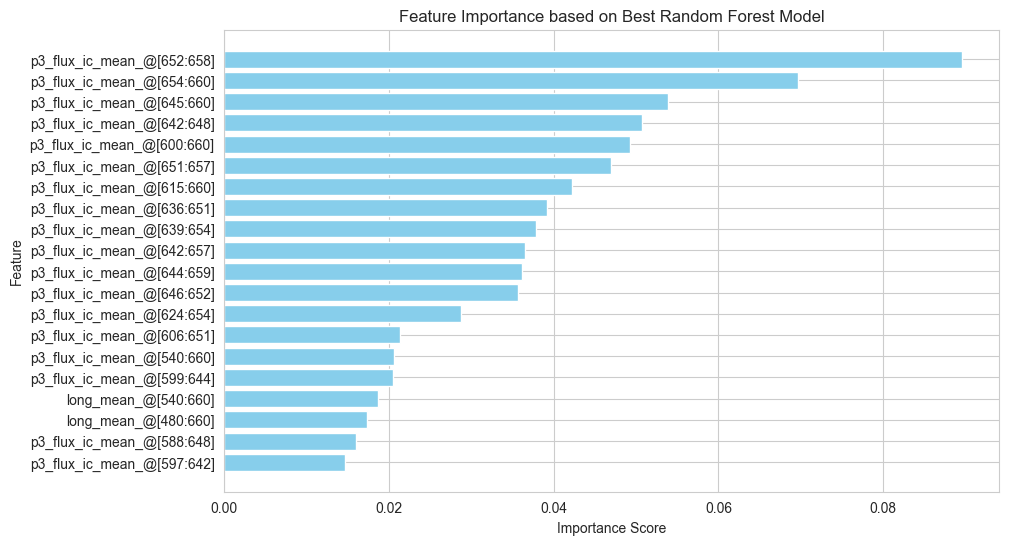

In [9]:
# Assuming `best_rf` is your trained Random Forest model
# and `X_train` contains the feature names

# Get feature importance scores
feature_importances = best_rf.feature_importances_

# Create a DataFrame to organize feature names and their importance scores
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})

# Sort by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(20)

# Display the top features
print(feature_importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance based on Best Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()


In [10]:
df_cfe = combined_df.drop(columns=['File']).copy()

#df_cfe = df_combined_labels.drop(["Label","File","Label.1"],axis=1)  # should contain the target column
cont_features = list(test_df.drop(["label"],axis=1).columns) #should not contain target column
# data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='label')
data= dice_ml.Data(dataframe=df_cfe, continuous_features=cont_features, outcome_name='Label')

In [11]:
# #Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
# cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
# #Create the Dice explainer
# exp_random = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="random") #method= ["genetic","kdtree","random"]
#
# # Save the explainer (DiCE model) using joblib
# joblib.dump(exp_random, "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_random_explainer.pkl")
#
# #use `exp` to generate counterfactual explanations
# print("\nRandom Dice explainer created successfully.\n")

In [12]:
# #Define a Model object using dice_ml.Model (we are using this CFE model for regressor type of prediction model
# cfe_model = dice_ml.Model(model=best_rf, backend="sklearn", model_type='classifier')
# #Create the Dice explainer
# exp_genetic = dice_ml.Dice(data_interface=data, model_interface=cfe_model, method="genetic") #method= ["genetic","kdtree","random"]
#
# # Save the explainer (DiCE model) using joblib
# joblib.dump(exp_genetic, "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_genetic_explainer_1.pkl")
#
# #use `exp` to generate counterfactual explanations
# print("\nGenetic Dice explainer created successfully.\n")

In [13]:
exp_random = joblib.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_random_explainer.pkl")
exp_genetic = joblib.load("/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/models/sep_cfe_slim_tsf_genetic_explainer.pkl")

In [14]:
p3_flux_cols = [col for col in train_df.columns if 'p3_flux_ic_mean' in col]
p5_flux_cols = [col for col in train_df.columns if 'p5_flux_ic_mean' in col]
p7_flux_cols = [col for col in train_df.columns if 'p7_flux_ic_mean' in col]
long_cols = [col for col in train_df.columns if 'long_mean' in col]

In [15]:
def process_header_list(header_list):
    """
    Extracts metric intervals from header names like:
        p3_flux_ic_mean_@[300:660]
    Returns list of tuples: (metric, slice_str, start, end)
    """
    pattern = r'^(p3_flux_ic_mean|p5_flux_ic_mean|p7_flux_ic_mean|long_mean)_@\[(\d+):(\d+)\]$'
    result = []
    for col in header_list:
        m = re.match(pattern, col)
        if m:
            metric = m.group(1)
            start, end = int(m.group(2)), int(m.group(3))
            slice_str = f"{start}:{end}"
            result.append((metric, slice_str, start, end))
    return result


def build_interval_dataframe(header_list):
    """
    Builds a long-format DataFrame from a list of header names.

    Output columns:
        metric | slice | start | end
    """
    entries = process_header_list(header_list)
    df = pd.DataFrame(entries, columns=["metric", "slice", "start", "end"])
    df.sort_values(["metric", "start", "end"], inplace=True)
    return df




# ==============================
# 🚀 Example Usage
# ==============================
header_list = train_df.columns.astype(str).str.cat(sep="\t").split()
print(header_list)

df_slices = build_interval_dataframe(header_list)
print("Interval dataframe:\n", df_slices)

all_slices = list(zip(df_slices["start"], df_slices["end"]))
print("All slices:\n", all_slices)

['long_mean_@[300:660]', 'long_mean_@[396:636]', 'long_mean_@[420:660]', 'long_mean_@[480:660]', 'long_mean_@[540:660]', 'p3_flux_ic_mean_@[300:480]', 'p3_flux_ic_mean_@[300:540]', 'p3_flux_ic_mean_@[300:660]', 'p3_flux_ic_mean_@[336:516]', 'p3_flux_ic_mean_@[348:588]', 'p3_flux_ic_mean_@[360:480]', 'p3_flux_ic_mean_@[372:552]', 'p3_flux_ic_mean_@[390:570]', 'p3_flux_ic_mean_@[396:636]', 'p3_flux_ic_mean_@[408:588]', 'p3_flux_ic_mean_@[420:540]', 'p3_flux_ic_mean_@[420:660]', 'p3_flux_ic_mean_@[435:525]', 'p3_flux_ic_mean_@[444:564]', 'p3_flux_ic_mean_@[444:624]', 'p3_flux_ic_mean_@[462:552]', 'p3_flux_ic_mean_@[468:588]', 'p3_flux_ic_mean_@[480:540]', 'p3_flux_ic_mean_@[480:570]', 'p3_flux_ic_mean_@[480:600]', 'p3_flux_ic_mean_@[480:660]', 'p3_flux_ic_mean_@[492:612]', 'p3_flux_ic_mean_@[498:588]', 'p3_flux_ic_mean_@[507:552]', 'p3_flux_ic_mean_@[510:570]', 'p3_flux_ic_mean_@[516:606]', 'p3_flux_ic_mean_@[516:636]', 'p3_flux_ic_mean_@[525:615]', 'p3_flux_ic_mean_@[530:575]', 'p3_flux_

In [16]:
len(all_slices)

94

In [17]:
def get_query_instance(query_ts_filename, df_combined_labels, model):
    """
    Retrieve the query instance and its target label for a given filename.

    Args:
           query_ts_filename (str): The filename identifying the query instance.
           df_combined_labels (pd.DataFrame): DataFrame containing labeled data.
           model: A trained classifier with a `.predict()` method.

    Returns:
        Tuple[pd.DataFrame, Any]: The query instance (features only) and its true label.
     """
    query_instance_raw = df_combined_labels[df_combined_labels['File'] == query_ts_filename]
    query_instance = query_instance_raw.drop(["Label","File"], axis=1)

    true_label = query_instance_raw["Label"].values[0]
    predicted_label = model.predict(query_instance)

    print("Target value for the query instance:\n", true_label)
    print("Predicted value:\n", predicted_label)

    return query_instance, true_label, predicted_label

In [18]:
# def get_pertubed_series(csv_path, sample_cfe, flux_type, slices, start_offset_min=300, end_offset_min=660):
#     """
#     Dynamically perturbs a flux time series using counterfactual mean adjustments.
#     Handles both pd.Series and pd.DataFrame for sample_cfe.
#     """
#     df = pd.read_csv(csv_path, delimiter=',')
#     df = df.rename(columns={'time_tag': 'time_stamp'})
#     df['time_stamp'] = pd.to_datetime(df['time_stamp'], errors='coerce')
#
#     # Subset to event window
#     event_start = df['time_stamp'].iloc[0] + timedelta(minutes=start_offset_min)
#     event_end   = df['time_stamp'].iloc[0] + timedelta(minutes=end_offset_min)
#     df_obs = df[(df['time_stamp'] >= event_start) & (df['time_stamp'] < event_end)].copy()
#     # print(f"Observations in event window: {df_obs}")
#     df_obs['minutes'] = (df_obs['time_stamp'] - event_start).dt.total_seconds() / 60
#
#     offset_accum = np.zeros_like(df_obs['minutes'], dtype=float)
#     offset_count = np.zeros_like(df_obs['minutes'], dtype=int)
#
#     # Handle Series or DataFrame case for sample_cfe
#     if isinstance(sample_cfe, pd.DataFrame):
#         sample_cfe = sample_cfe.iloc[0]
#
#     for start_min, end_min in slices:
#         mask = (df_obs['minutes'] >= start_min) & (df_obs['minutes'] < end_min)
#         if not np.any(mask):
#             continue
#
#         pattern = f"^{flux_type}_mean_@\\[{start_min}:{end_min}\\]$"
#         matched_cols = sample_cfe.filter(regex=pattern)
#
#         if matched_cols.empty:
#             # print(f"[WARN] Missing slice for {pattern}")
#             continue
#
#         # Extract single value safely
#         if isinstance(matched_cols, pd.Series):
#             cfe_value = matched_cols.iloc[0]
#         else:
#             cfe_value = matched_cols.iloc[0, 0]
#
#         flux_data = df_obs.loc[mask, flux_type].values
#         print(f"Flux data for slice {start_min}-{end_min} mins: {flux_data}")
#         global_adjustment = cfe_value - flux_data.mean()
#         adjusted = flux_data + global_adjustment
#
#         offset_accum[mask] += adjusted
#         offset_count[mask] += 1
#
#     # Compute average adjustments
#     final_offset = np.zeros_like(df_obs['minutes'], dtype=float)
#     nonzero = offset_count > 0
#     final_offset[nonzero] = offset_accum[nonzero] / offset_count[nonzero]
#
#     # Build final series
#     original = df_obs[flux_type].values
#     final_series = original + final_offset
#
#     return (
#         df_obs,
#         pd.Series(final_series, index=df_obs.index),
#         pd.Series(original, index=df_obs.index),
#         float(min(final_series.min(), original.min())),
#         float(max(final_series.max(), original.max())),
#     )


In [33]:
def get_pertubed_series(
    csv_path,
    sample_cfe,
    flux_type,
    header_list,
    start_offset_min=300,
    end_offset_min=660,
):
    """
    Perturb flux series based only on intervals that appear in header_list,
    matching pattern:  f"{flux_type}_mean_@[start:end]".

    Uses SAME overlapping-average-adjustment logic as your original implementation.
    """

    # -------------------------
    # Load CSV and slice window
    # -------------------------
    df = pd.read_csv(csv_path, delimiter=",")
    df = df.rename(columns={"time_tag": "time_stamp"})
    df["time_stamp"] = pd.to_datetime(df["time_stamp"], errors="coerce")

    event_start = df["time_stamp"].iloc[0] + timedelta(minutes=start_offset_min)
    event_end   = df["time_stamp"].iloc[0] + timedelta(minutes=end_offset_min)

    df_obs = df[(df["time_stamp"] >= event_start) &
                (df["time_stamp"] < event_end)].copy()

    df_obs["minutes"] = (df_obs["time_stamp"] - event_start).dt.total_seconds() / 60

    # Prepare accumulators
    offset_accum = np.zeros(len(df_obs), dtype=float)
    offset_count = np.zeros(len(df_obs), dtype=int)

    # sample_cfe row
    if isinstance(sample_cfe, pd.DataFrame):
        sample_cfe = sample_cfe.iloc[0]

    # -------------------------------------------------------------
    # Extract only the slices that match THIS flux_type
    # Pattern example: p3_flux_ic_mean_@[420:660]
    # -------------------------------------------------------------
    pattern = re.compile(rf"^{flux_type}_mean_@\[(\d+):(\d+)\]$")

    relevant_intervals = []

    for col in header_list:
        m = pattern.match(col)
        if m:
            abs_start = int(m.group(1))
            abs_end   = int(m.group(2))
            relevant_intervals.append((abs_start, abs_end))

    # ------------------------------------------
    # Apply adjustments for each matched interval
    # ------------------------------------------
    for abs_start, abs_end in relevant_intervals:

        # convert absolute → local window minutes
        local_start = abs_start - start_offset_min
        local_end   = abs_end   - start_offset_min

        mask = (df_obs["minutes"] >= local_start) & (df_obs["minutes"] < local_end)
        if not np.any(mask):
            continue

        col_name = f"{flux_type}_mean_@[{abs_start}:{abs_end}]"

        if col_name not in sample_cfe.index:
            continue  # skip missing in CFE

        cfe_value = sample_cfe[col_name]

        flux_data = df_obs.loc[mask, flux_type].values
        old_mean = flux_data.mean()
        print(f"Flux data for {flux_type} for slice {local_start}-{local_end} mins: {flux_data}, old_mean: {old_mean}, cfe_value: {cfe_value}")
        # shift entire window to correct mean
        global_adjustment = cfe_value - old_mean
        adjusted = flux_data + global_adjustment

        # accumulate for overlapping windows
        offset_accum[mask] += adjusted
        offset_count[mask] += 1

    # -----------------------
    # Build final perturbed y
    # -----------------------
    final_offset = np.zeros(len(df_obs), dtype=float)
    nz = offset_count > 0
    final_offset[nz] = offset_accum[nz] / offset_count[nz]

    original = df_obs[flux_type].to_numpy()
    final_series = original + final_offset

    return (
        df_obs,
        pd.Series(final_series, index=df_obs.index),
        pd.Series(original, index=df_obs.index),
        float(min(final_series.min(), original.min())),
        float(max(final_series.max(), original.max())),
    )


In [20]:
query_ts_filename = '2003-06-18_12-15.csv'
query_instance1, class_label, predicted_label = get_query_instance(query_ts_filename, combined_df, best_rf)

cfe_label = 0 if predicted_label[0] == 1 else 1

print(f"cfe_label: {cfe_label}")
cfe_exp = []
df_cfe_exp_genetic_1 = pd.DataFrame()
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance1,  #multiple query instances can be provided as an input dataframe
    total_CFs=1,  # Number of counterfactual examples to generate
    desired_class=cfe_label,  #'opposite' #,  # Specify the desired class for a continuous target variable
    #permitted_range={'variable1': [20, 30], 'variable2': ['val1', 'val2']}
    # features_to_vary=top_k_features,
    # proximity_weight=pw,
    # diversity_weight=dw
    # feature_weights=sorted_normalized_weights_dict
)

cfe_genetic.visualize_as_dataframe(show_only_changes=True)
df_cfe_exp_genetic_1 = cfe_genetic.cf_examples_list[0].final_cfs_df


Target value for the query instance:
 1
Predicted value:
 [1]
cfe_label: 0


100%|██████████| 1/1 [00:00<00:00,  5.58it/s]

Query instance (original outcome : 1)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,6.865437e-07,6.759881e-07,6.498988e-07,6.483254e-07,6.073215e-07,4.023111,4.469542,5.358861,4.213056,5.224608,...,0.060455,0.059797,0.057512,0.060251,0.054849,0.060245,0.021987,0.021026,0.021407,1



Diverse Counterfactual set (new outcome: 0)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,3.375754e-06,2.450952e-06,2.189e-06,1.93294e-06,1.77333e-06,4.637610912,4.519666672,4.145833492,4.607089043,4.423741817,...,0.074,0.071,0.07,0.062,0.063,0.061,0.0292,0.0288,0.029,0.0


Flux data for p3_flux_ic for slice 0-180 mins: [4.8   4.658 4.516 4.374 4.232 4.09  4.32  4.55  4.78  5.01  5.24  5.05
 4.86  4.67  4.48  4.29  4.35  4.41  4.47  4.53  4.59  4.37  4.15  3.93
 3.71  3.49  3.374 3.258 3.142 3.026 2.91  3.122 3.334 3.546 3.758 3.97
 3.962 3.954 3.946 3.938 3.93  3.824 3.718 3.612 3.506 3.4   3.542 3.684
 3.826 3.968 4.11  4.048 3.986 3.924 3.862 3.8   3.806 3.812 3.818 3.824
 3.83  4.068 4.306 4.544 4.782 5.02  4.932 4.844 4.756 4.668 4.58  4.756
 4.932 5.108 5.284 5.46  5.094 4.728 4.362 3.996 3.63  3.672 3.714 3.756
 3.798 3.84  3.928 4.016 4.104 4.192 4.28  4.31  4.34  4.37  4.4   4.43
 4.25  4.07  3.89  3.71  3.53  3.628 3.726 3.824 3.922 4.02  3.842 3.664
 3.486 3.308 3.13  3.322 3.514 3.706 3.898 4.09  4.018 3.946 3.874 3.802
 3.73  3.868 4.006 4.144 4.282 4.42  4.466 4.512 4.558 4.604 4.65  4.426
 4.202 3.978 3.754 3.53  3.648 3.766 3.884 4.002 4.12  3.994 3.868 3.742
 3.616 3.49  3.414 3.338 3.262 3.186 3.11  3.248 3.386 3.524 3.662 3.8
 3.784 3.7

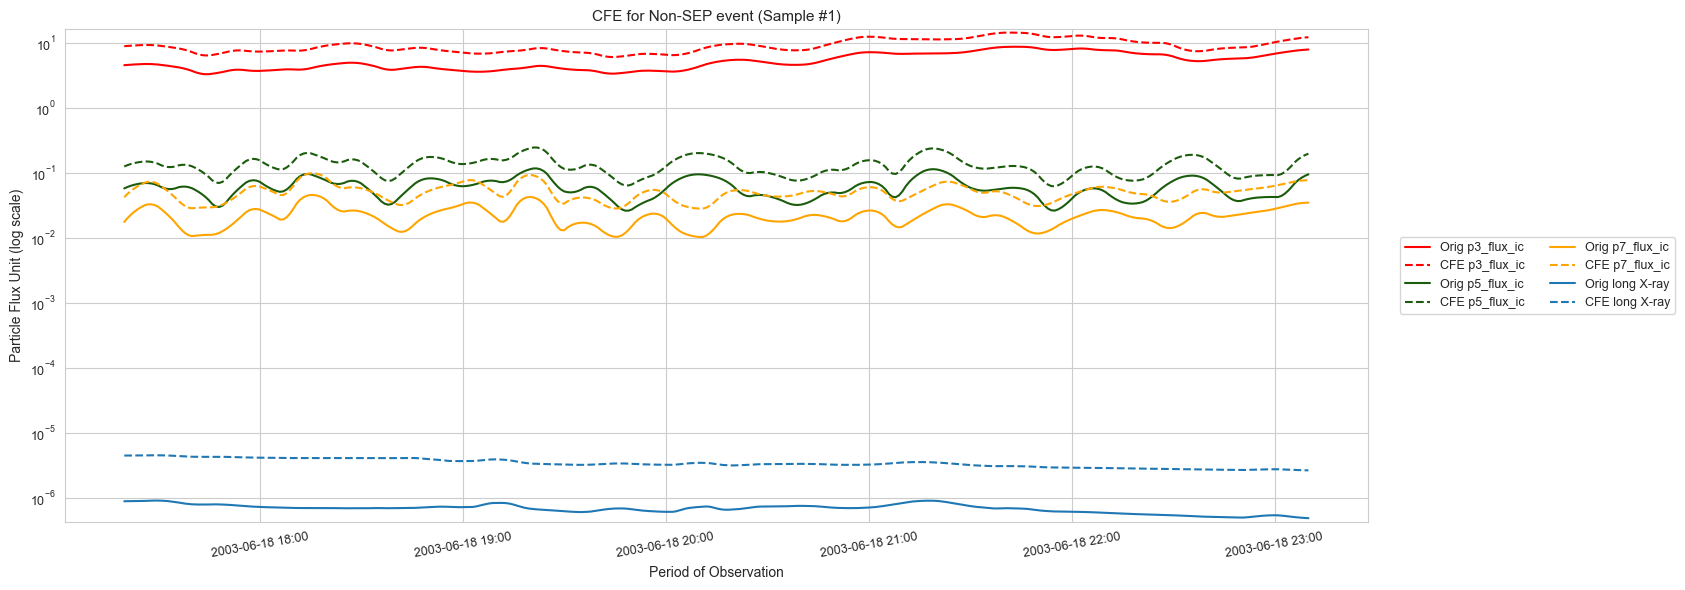

In [34]:
window_size = 10
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
csv_path = os.path.join(CSV_DATA_DIR, query_ts_filename)

fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")

# choose the CFE to display; loop if you like, or just pick one
cfe_idx = 0
sample_cfe = df_cfe_exp_genetic_1.iloc[cfe_idx]

# p3
flux_type = "p3_flux_ic"
df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p3 = original_p3.rolling(window=window_size, center=True).mean()
cf_p3 = pd.Series(final_series_p3).rolling(window=window_size, center=True).mean()

# p5
flux_type = "p5_flux_ic"
df_obs1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p5 = original_p5.rolling(window=window_size, center=True).mean()
cf_p5 = pd.Series(final_series_p5).rolling(window=window_size, center=True).mean()

# p7
flux_type = "p7_flux_ic"
df_obs2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p7 = original_p7.rolling(window=window_size, center=True).mean()
cf_p7 = pd.Series(final_series_p7).rolling(window=window_size, center=True).mean()

# long mean
flux_type = "long"
df_obs3, final_series_long, original_long, min_y_l, max_y_l = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_l = original_long.rolling(window=window_size, center=True).mean()
cf_l = pd.Series(final_series_long).rolling(window=window_size, center=True).mean()

# combine limits
ymin = min(min_y_p3, min_y_p5, min_y_p7, min_y_l)
ymax = max(max_y_p3, max_y_p5, max_y_p7, max_y_l)

# single axis plotting
ax.set_facecolor("white")
ax.plot(df_obs["time_stamp"], orig_p3, label="Orig p3_flux_ic", color="#FF0000")
ax.plot(df_obs["time_stamp"], cf_p3, label="CFE p3_flux_ic", color="#FF0000", ls="--")
ax.plot(df_obs1["time_stamp"], orig_p5, label="Orig p5_flux_ic", color="#1b5c0c")
ax.plot(df_obs1["time_stamp"], cf_p5, label="CFE p5_flux_ic", color="#1b5c0c", ls="--")
ax.plot(df_obs2["time_stamp"], orig_p7, label="Orig p7_flux_ic", color="#FFA500")
ax.plot(df_obs2["time_stamp"], cf_p7, label="CFE p7_flux_ic", color="#FFA500", ls="--")
ax.plot(df_obs3["time_stamp"], orig_l, label="Orig long X-ray", color="#1f77b4")
ax.plot(df_obs3["time_stamp"], cf_l, label="CFE long X-ray", color="#1f77b4", ls="--")

ax.set_yscale("log")
ax.set_ylim(ymin * 0.9, ymax * 1.1)
ax.set_xlabel("Period of Observation", fontsize=10)
ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)
label_str = "SEP-Event" if class_label == 1 else "Non-SEP event"
ax.set_title(f"CFE for {label_str} (Sample #{cfe_idx+1})", fontsize=11)
ax.legend(
    loc="center left",         # position anchor (relative to axes)
    bbox_to_anchor=(1.02, 0.5),# shift legend box outside the right edge
    ncol=2,                    # 2-column layout
    frameon=True,
    fontsize=9
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # make room on the right side
plt.show()



##2017-09-09_21-04.csv

In [22]:
query_ts2_filename = '2017-09-09_21-04.csv'
query_instance2, class_label, predicted_label = get_query_instance(query_ts2_filename, combined_df, best_rf)

cfe_label = 0 if predicted_label[0] == 1 else 1

print(f"cfe_label: {cfe_label}")
cfe_exp = []
df_cfe_exp_genetic_2 = pd.DataFrame()
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance2,  #multiple query instances can be provided as an input dataframe
    total_CFs=1,  # Number of counterfactual examples to generate
    desired_class=cfe_label,  #'opposite' #,  # Specify the desired class for a continuous target variable
    #permitted_range={'variable1': [20, 30], 'variable2': ['val1', 'val2']}
    # features_to_vary=top_k_features,
    # proximity_weight=pw,
    # diversity_weight=dw
    # feature_weights=sorted_normalized_weights_dict
)

cfe_genetic.visualize_as_dataframe(show_only_changes=True)
df_cfe_exp_genetic_2 = cfe_genetic.cf_examples_list[0].final_cfs_df


Target value for the query instance:
 0
Predicted value:
 [0]
cfe_label: 1


100%|██████████| 1/1 [00:00<00:00,  5.94it/s]

Query instance (original outcome : 0)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,0.000002,0.000001,0.000001,7.684888e-07,7.037311e-07,0.156576,0.169427,0.16567,0.158692,0.164915,...,0.076208,0.076467,0.078986,0.071036,0.073907,0.073235,0.045335,0.044604,0.044382,0



Diverse Counterfactual set (new outcome: 1)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,3.495001e-06,4.345161e-06,5.173e-06,6.84982e-06,1.017823e-05,0.163733333,0.170545831,0.195558339,0.171694443,0.174217507,...,0.076,0.091,0.096,0.106,0.112,0.139,0.0383,0.0392,0.0414,1.0


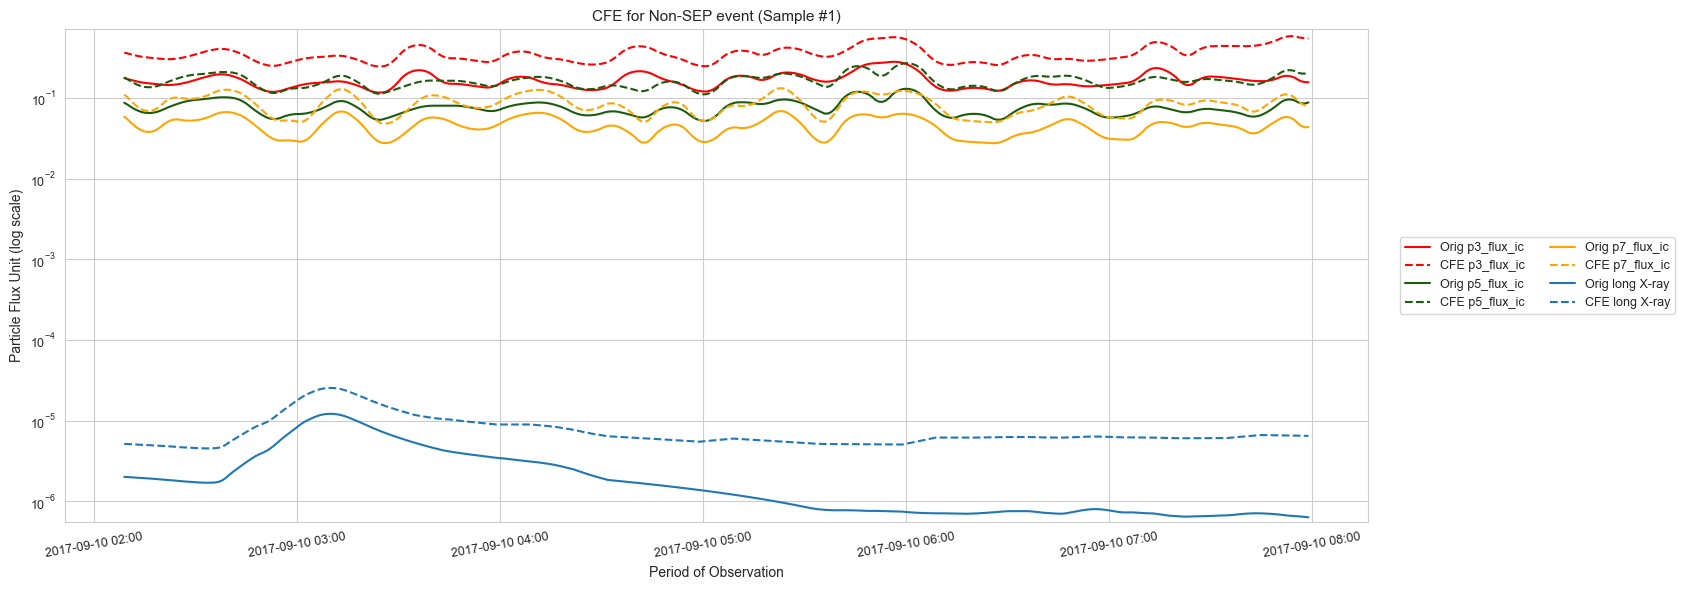

In [29]:
window_size = 10
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
csv_path = os.path.join(CSV_DATA_DIR, query_ts2_filename)

fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")

# choose the CFE to display; loop if you like, or just pick one
cfe_idx = 0
sample_cfe = df_cfe_exp_genetic_2.iloc[cfe_idx]

# p3
flux_type = "p3_flux_ic"
df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p3 = original_p3.rolling(window=window_size, center=True).mean()
cf_p3 = pd.Series(final_series_p3).rolling(window=window_size, center=True).mean()

# p5
flux_type = "p5_flux_ic"
df_obs1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p5 = original_p5.rolling(window=window_size, center=True).mean()
cf_p5 = pd.Series(final_series_p5).rolling(window=window_size, center=True).mean()

# p7
flux_type = "p7_flux_ic"
df_obs2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p7 = original_p7.rolling(window=window_size, center=True).mean()
cf_p7 = pd.Series(final_series_p7).rolling(window=window_size, center=True).mean()

# long mean
flux_type = "long"
df_obs3, final_series_long, original_long, min_y_l, max_y_l = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_l = original_long.rolling(window=window_size, center=True).mean()
cf_l = pd.Series(final_series_long).rolling(window=window_size, center=True).mean()

# combine limits
ymin = min(min_y_p3, min_y_p5, min_y_p7, min_y_l)
ymax = max(max_y_p3, max_y_p5, max_y_p7, max_y_l)

# single axis plotting
ax.set_facecolor("white")
ax.plot(df_obs["time_stamp"], orig_p3, label="Orig p3_flux_ic", color="#FF0000")
ax.plot(df_obs["time_stamp"], cf_p3, label="CFE p3_flux_ic", color="#FF0000", ls="--")
ax.plot(df_obs1["time_stamp"], orig_p5, label="Orig p5_flux_ic", color="#1b5c0c")
ax.plot(df_obs1["time_stamp"], cf_p5, label="CFE p5_flux_ic", color="#1b5c0c", ls="--")
ax.plot(df_obs2["time_stamp"], orig_p7, label="Orig p7_flux_ic", color="#FFA500")
ax.plot(df_obs2["time_stamp"], cf_p7, label="CFE p7_flux_ic", color="#FFA500", ls="--")
ax.plot(df_obs3["time_stamp"], orig_l, label="Orig long X-ray", color="#1f77b4")
ax.plot(df_obs3["time_stamp"], cf_l, label="CFE long X-ray", color="#1f77b4", ls="--")

ax.set_yscale("log")
ax.set_ylim(ymin * 0.9, ymax * 1.1)
ax.set_xlabel("Period of Observation", fontsize=10)
ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)
label_str = "SEP-Event" if class_label == 1 else "Non-SEP event"
ax.set_title(f"CFE for {label_str} (Sample #{cfe_idx+1})", fontsize=11)
ax.legend(
    loc="center left",         # position anchor (relative to axes)
    bbox_to_anchor=(1.02, 0.5),# shift legend box outside the right edge
    ncol=2,                    # 2-column layout
    frameon=True,
    fontsize=9
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # make room on the right side
plt.show()


In [24]:
query_ts3_filename = '2003-11-20_18-08.csv'
query_instance3, class_label, predicted_label = get_query_instance(query_ts3_filename, combined_df, best_rf)

cfe_label = 0 if predicted_label[0] == 1 else 1

print(f"cfe_label: {cfe_label}")
cfe_exp = []
df_cfe_exp_genetic_3 = pd.DataFrame()
cfe_genetic = exp_genetic.generate_counterfactuals(
    query_instance2,  #multiple query instances can be provided as an input dataframe
    total_CFs=1,  # Number of counterfactual examples to generate
    desired_class=cfe_label,  #'opposite' #,  # Specify the desired class for a continuous target variable
    #permitted_range={'variable1': [20, 30], 'variable2': ['val1', 'val2']}
    # features_to_vary=top_k_features,
    # proximity_weight=pw,
    # diversity_weight=dw
    # feature_weights=sorted_normalized_weights_dict
)

cfe_genetic.visualize_as_dataframe(show_only_changes=True)
df_cfe_exp_genetic_3 = cfe_genetic.cf_examples_list[0].final_cfs_df


Target value for the query instance:
 0
Predicted value:
 [0]
cfe_label: 1


100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

Query instance (original outcome : 0)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,0.000002,0.000001,0.000001,7.684888e-07,7.037311e-07,0.156576,0.169427,0.16567,0.158692,0.164915,...,0.076208,0.076467,0.078986,0.071036,0.073907,0.073235,0.045335,0.044604,0.044382,0



Diverse Counterfactual set (new outcome: 1)


,long_mean_@[300:660],long_mean_@[396:636],long_mean_@[420:660],long_mean_@[480:660],long_mean_@[540:660],p3_flux_ic_mean_@[300:480],p3_flux_ic_mean_@[300:540],p3_flux_ic_mean_@[300:660],p3_flux_ic_mean_@[336:516],p3_flux_ic_mean_@[348:588],...,p5_flux_ic_mean_@[396:636],p5_flux_ic_mean_@[420:660],p5_flux_ic_mean_@[480:660],p5_flux_ic_mean_@[540:660],p5_flux_ic_mean_@[570:660],p5_flux_ic_mean_@[600:660],p7_flux_ic_mean_@[300:660],p7_flux_ic_mean_@[396:636],p7_flux_ic_mean_@[420:660],label
0,3.495001e-06,4.345161e-06,5.173e-06,6.84982e-06,1.017823e-05,0.163733333,0.170545831,0.195558339,0.171694443,0.174217507,...,0.076,0.091,0.096,0.106,0.112,0.139,0.0383,0.0392,0.0414,1.0


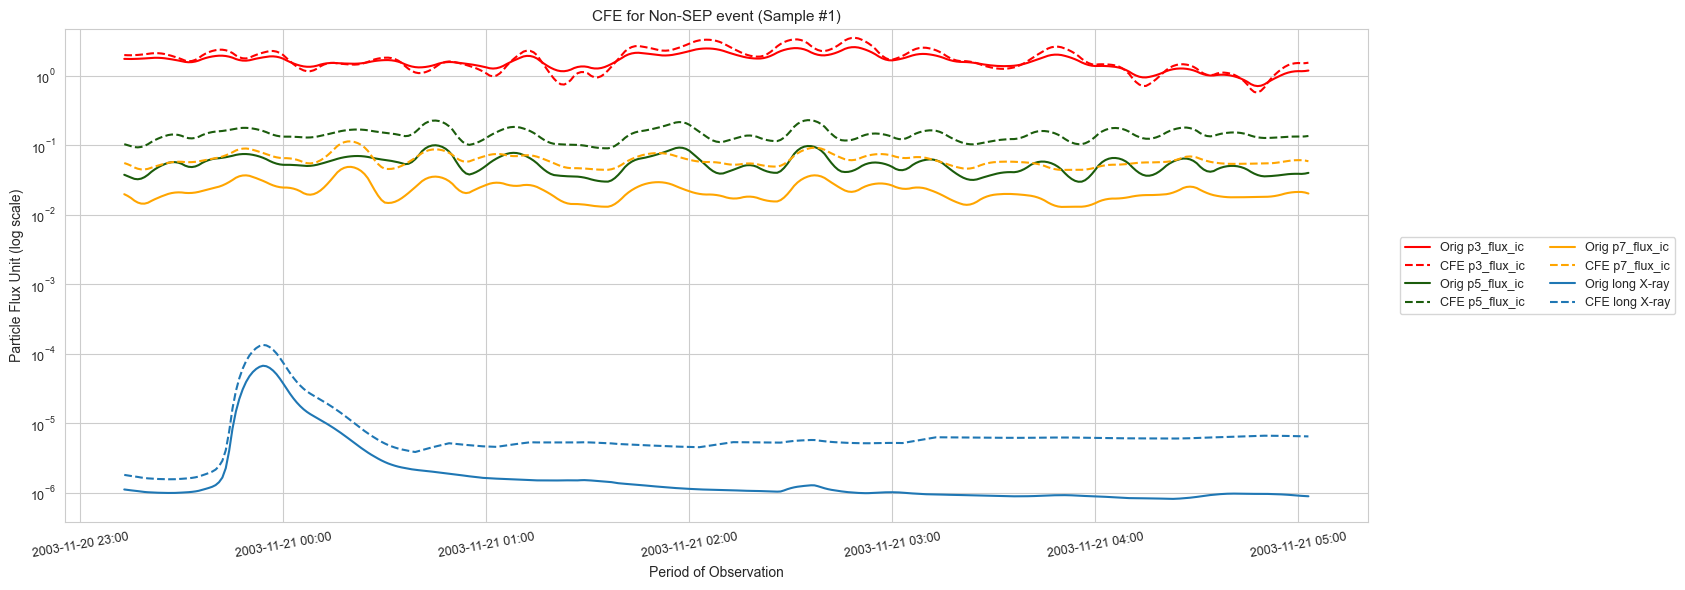

In [30]:
window_size = 10
CSV_DATA_DIR = "/Users/pranjal/PycharmProjects/SolarEnergyParticlePrediction/data/raw/data/"
csv_path = os.path.join(CSV_DATA_DIR, query_ts3_filename)

fig, ax = plt.subplots(figsize=(20, 6), facecolor="white")

# choose the CFE to display; loop if you like, or just pick one
cfe_idx = 0
sample_cfe = df_cfe_exp_genetic_3.iloc[cfe_idx]

# p3
flux_type = "p3_flux_ic"
df_obs, final_series_p3, original_p3, min_y_p3, max_y_p3 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p3 = original_p3.rolling(window=window_size, center=True).mean()
cf_p3 = pd.Series(final_series_p3).rolling(window=window_size, center=True).mean()

# p5
flux_type = "p5_flux_ic"
df_obs1, final_series_p5, original_p5, min_y_p5, max_y_p5 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p5 = original_p5.rolling(window=window_size, center=True).mean()
cf_p5 = pd.Series(final_series_p5).rolling(window=window_size, center=True).mean()

# p7
flux_type = "p7_flux_ic"
df_obs2, final_series_p7, original_p7, min_y_p7, max_y_p7 = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_p7 = original_p7.rolling(window=window_size, center=True).mean()
cf_p7 = pd.Series(final_series_p7).rolling(window=window_size, center=True).mean()

# long mean
flux_type = "long"
df_obs3, final_series_long, original_long, min_y_l, max_y_l = get_pertubed_series(
    csv_path, sample_cfe, flux_type, header_list, 300, 660
)
orig_l = original_long.rolling(window=window_size, center=True).mean()
cf_l = pd.Series(final_series_long).rolling(window=window_size, center=True).mean()

# combine limits
ymin = min(min_y_p3, min_y_p5, min_y_p7, min_y_l)
ymax = max(max_y_p3, max_y_p5, max_y_p7, max_y_l)

# single axis plotting
ax.set_facecolor("white")
ax.plot(df_obs["time_stamp"], orig_p3, label="Orig p3_flux_ic", color="#FF0000")
ax.plot(df_obs["time_stamp"], cf_p3, label="CFE p3_flux_ic", color="#FF0000", ls="--")
ax.plot(df_obs1["time_stamp"], orig_p5, label="Orig p5_flux_ic", color="#1b5c0c")
ax.plot(df_obs1["time_stamp"], cf_p5, label="CFE p5_flux_ic", color="#1b5c0c", ls="--")
ax.plot(df_obs2["time_stamp"], orig_p7, label="Orig p7_flux_ic", color="#FFA500")
ax.plot(df_obs2["time_stamp"], cf_p7, label="CFE p7_flux_ic", color="#FFA500", ls="--")
ax.plot(df_obs3["time_stamp"], orig_l, label="Orig long X-ray", color="#1f77b4")
ax.plot(df_obs3["time_stamp"], cf_l, label="CFE long X-ray", color="#1f77b4", ls="--")

ax.set_yscale("log")
ax.set_ylim(ymin * 0.9, ymax * 1.1)
ax.set_xlabel("Period of Observation", fontsize=10)
ax.set_ylabel("Particle Flux Unit (log scale)", fontsize=10)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
plt.setp(ax.get_xticklabels(), rotation=10, ha="center", fontsize=9)
plt.setp(ax.get_yticklabels(), fontsize=9)
label_str = "SEP-Event" if class_label == 1 else "Non-SEP event"
ax.set_title(f"CFE for {label_str} (Sample #{cfe_idx+1})", fontsize=11)
ax.legend(
    loc="center left",         # position anchor (relative to axes)
    bbox_to_anchor=(1.02, 0.5),# shift legend box outside the right edge
    ncol=2,                    # 2-column layout
    frameon=True,
    fontsize=9
)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # make room on the right side
plt.show()
